In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git


  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/91/f8/dfa32d06cfcbdb76bc46e0f5d69c537de33f4cedb1a15cd4746ab45a6a26/ftfy-6.1.3-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/31/b1/a59de0ad3aabb17523a39804f4c6df3ae87ead053a4e25362ae03d73d03a/wcwidth-0.2.12-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-0.2.6:
      Successfully uninstalled wcwidth-0.2.6
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wkp3k5qy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wkp3k5qy
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for cl

In [ ]:
! pip install coop

In [14]:
import torch
from PIL import Image
from torchvision import transforms
from pathlib import Path
from sklearn.model_selection import train_test_split
import clip

# 加载CLIP模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

# 定义图像预处理
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 将灰度图像转换为RGB图像
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 加载Caltech101数据集
data_dir = Path("/kaggle/input/d/mytoumakazusa/caltech101/caltech-101")
image_paths = list(data_dir.glob("*/*.jpg")) 
labels = [path.parent.name for path in image_paths]

# 划分训练集和测试集
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2,random_state=42,shuffle=True)

# 对测试集中的每个类别生成一个描述
class_descriptions = [f"A photo of a {label}" for label in set(test_labels)]

# 将类别描述转化为CLIP可以理解的形式
text_inputs = torch.cat([clip.tokenize(description).to(device) for description in class_descriptions])

with torch.no_grad():
    # 提取类别描述的特征
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)

# 对测试集中的每张图片进行分类
correct_predictions = 0
for path in test_paths:
    with Image.open(path) as img:
        # 预处理图片并提取特征
        #print(path)
        image_input = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            image_features /= image_features.norm(dim=-1, keepdim=True)

        # 计算图片特征和每个类别描述特征之间的相似性
        similarities = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarities[0].topk(1)

        # 输出预测的类别
        predicted_label = class_descriptions[indices[0]]
        #print(f"Image {path} is predicted to be in class {predicted_label} with a similarity of {values[0]}%")

        # 计算正确率
        if predicted_label == f"A photo of a {path.parent.name}":
            correct_predictions += 1

# 输出总的正确率
accuracy = correct_predictions / len(test_paths)
print(f"Total accuracy: {accuracy}")


Total accuracy: 0.7586405529953917


In [3]:
from torch.nn import functional as F
from clip import clip
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Caltech101
from torchvision import transforms
from tqdm import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt

# 加载 CLIP RN50 模型
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _ = clip.load("RN50", device=device)


class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.categories = os.listdir(directory)
        self.category_to_index = {category: index for index, category in enumerate(self.categories)}
        self.image_files = self.get_image_files()

    def get_image_files(self, max_files_per_category=1):
        image_files = []
        for category in self.categories:
            category_path = os.path.join(self.directory, category)
            file_count = 0
            for file_name in os.listdir(category_path):
                if file_count >= max_files_per_category:
                    break
                file_path = os.path.join(category_path, file_name)
                image_files.append((file_path, self.category_to_index[category]))
                file_count += 1
        return image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        file_path, label = self.image_files[index]
        img = Image.open(file_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return {"img": img, "label": label}

class OptimizedContext(nn.Module):
    def __init__(self, config, class_labels, model_clip):
        super().__init__()
        self.prompt_trainer = PromptLearner(config, class_labels, model_clip)
        self.token_prompts = self.prompt_trainer.tokenized_prompts
        self.encoder_image = model_clip.visual
        self.encoder_text = PromptEncoder(model_clip)
        self.scale_logit = model_clip.logit_scale
        self.dtype = model_clip.dtype

    def forward(self, img):
        img = img.to(self.dtype)
        features_img = self.encoder_image(img.type(self.dtype))
        prompts = self.prompt_trainer()
        token_prompts = self.token_prompts
        features_text = self.encoder_text(prompts, token_prompts)
        features_img = features_img / features_img.norm(dim=-1, keepdim=True)
        features_text = features_text / features_text.norm(dim=-1, keepdim=True)
        scale_logit = self.scale_logit.exp()
        logits = scale_logit * features_img @ features_text.t()
        return logits

class PromptLearner(nn.Module):
    def __init__(self, config, class_labels, model_clip):
        super().__init__()
        num_classes = len(class_labels)
        num_context = config["TRAINER"]["COOP"]["N_CTX"]
        context_init = config["TRAINER"]["COOP"]["CTX_INIT"]
        dtype = model_clip.dtype
        context_dim = model_clip.ln_final.weight.shape[0]
        clip_image_size = model_clip.visual.input_resolution
        config_image_size = config.get("INPUT", {}).get("SIZE", (224, 224))[0]
        assert config_image_size == clip_image_size, f"config_image_size ({config_image_size}) must equal to clip_image_size ({clip_image_size})"
        if context_init:
            # 使用给定的单词初始化上下文向量
            context_init = context_init.replace("_", " ")
            num_context = len(context_init.split(" "))
            prompt = clip.tokenize(context_init)
            with torch.no_grad():
                embedding = model_clip.token_embedding(prompt).type(dtype)
            context_vectors = embedding[0, 1: 1 + num_context, :]
            prompt_prefix = context_init

        else:
            # 随机初始化
            if config["TRAINER"]["COOP"]["CSC"]:
                print("初始化类别特定的上下文")
                context_vectors = torch.empty(num_classes, num_context, context_dim, dtype=dtype)
            else:
                print("初始化通用上下文")
                context_vectors = torch.empty(num_context, context_dim, dtype=dtype)
            nn.init.normal_(context_vectors, mean=0, std=0.02)
            prompt_prefix = " ".join(["X"] * num_context)
        print(f'初始上下文: "{prompt_prefix}"')
        print(f"上下文单词（标记）数量: {num_context}")
        self.context = nn.Parameter(context_vectors)  # 待优化
        class_labels = [label.replace("_", " ") for label in class_labels]
        label_lengths = [len(_tokenizer.encode(label)) for label in class_labels]
        prompts = [prompt_prefix + " " + label + "." for label in class_labels]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts])
        tokenized_prompts = tokenized_prompts.to(device)
        with torch.no_grad():
            embedding = model_clip.token_embedding(tokenized_prompts).type(dtype)
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + num_context:, :])  # CLS, EOS
        self.num_classes = num_classes
        self.num_context = num_context
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.label_lengths = label_lengths
        self.class_token_position = config["TRAINER"]["COOP"]["CLASS_TOKEN_POSITION"]

    def forward(self):
        context = self.context
        if context.dim() == 2:
            context = context.unsqueeze(0).expand(self.num_classes, -1, -1)
        prefix = self.token_prefix
        suffix = self.token_suffix
        if self.class_token_position == "end":
            prompts = torch.cat(
                [
                    prefix,  # (num_classes, 1, dim)
                    context,  # (num_classes, num_context, dim)
                    suffix,  # (num_classes, *, dim)
                ], dim=1,
            )
        elif self.class_token_position == "middle":
            half_num_context = self.num_context // 2
            prompts = []
            for i in range(self.num_classes):
                label_len = self.label_lengths[i]
                prefix_i = prefix[i: i + 1, :, :]
                class_i = suffix[i: i + 1, :label_len, :]
                suffix_i = suffix[i: i + 1, label_len:, :]
                context_i_half1 = context[i: i + 1, :half_num_context, :]
                context_i_half2 = context[i: i + 1, half_num_context:, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        context_i_half1,  # (1, num_context//2, dim)
                        class_i,  # (1, label_len, dim)
                        context_i_half2,  # (1, num_context//2, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)
        return prompts
    
class PromptEncoder(nn.Module):
    def __init__(self, model_clip):
        super().__init__()
        self.transformer = model_clip.transformer
        self.positional_embedding = model_clip.positional_embedding
        self.ln_final = model_clip.ln_final
        self.text_projection = model_clip.text_projection
        self.dtype = model_clip.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x


_tokenizer = _Tokenizer()

# 数据预处理和划分
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ImageDataset(directory='/kaggle/input/d/mytoumakazusa/caltech101/caltech-101',
                       transform=transform)
print(len(dataset))
class_names = dataset.categories
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# 根据shot数量设置不同的epoch
num_epochs_1shot, num_epochs_2shot, num_epochs_4shot = 50, 100, 100

# 选择不同的数据集和epoch
shot_to_dataset = {1: dataset, 2: dataset, 4: dataset}
shot_to_epochs = {1: num_epochs_1shot, 2: num_epochs_2shot, 4: num_epochs_4shot}

# 定义 DataLoader
batch_size = 32  # 你可以根据需要进行调整
train_data = shot_to_dataset[1]  # 选择1-shot的数据集
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

cfg = {
    "MODEL": {"BACKBONE": {"NAME": "RN50"}},
    "TRAINER": {
        "COOP": {
            "N_CTX": 16,
            "CTX_INIT": None,  # 这里可以设置为你需要的初始化内容
            "CLASS_TOKEN_POSITION": "end",
            "CSC": False,
        },
    },
    "OPTIM": {
        "NAME": "SGD",
        "BASE_LR": 0.002,
        "MOMENTUM": 0.9,
        "WEIGHT_DECAY": 1e-4,
    },
    "INPUT": {
        "SIZE": (224, 224),  # 请根据你的需要设置正确的输入尺寸
    },
}

# 构建模型
model = OptimizedContext(cfg, class_names, model_clip=clip_model)
model = model.to("cuda")

# 初始化 Text Embedding
nn.init.normal_(model.prompt_trainer.context, mean=0, std=0.02)

# 设置优化器和学习率调度器
optimizer = SGD(model.parameters(), lr=cfg["OPTIM"]["BASE_LR"], momentum=cfg["OPTIM"]["MOMENTUM"],
                weight_decay=cfg["OPTIM"]["WEIGHT_DECAY"])

# 使用余弦退火调整学习率
scheduler = CosineAnnealingLR(optimizer, T_max=shot_to_epochs[1], eta_min=1e-5)

# 训练循环
for epoch in range(1, num_epochs_1shot + 1):
    model.train()
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs_1shot}"):
        image, label = batch["img"].to("cuda"), batch["label"].to("cuda")
        optimizer.zero_grad()
        output = model(image)
        loss = F.cross_entropy(output, label)
        loss.backward()
        optimizer.step()
    scheduler.step()

# 保存模型
torch.save(model.state_dict(), "1shot_model_0.pth")



100%|███████████████████████████████████████| 244M/244M [00:12<00:00, 20.5MiB/s]


101
初始化通用上下文
初始上下文: "X X X X X X X X X X X X X X X X"
上下文单词（标记）数量: 16


Epoch 50/50: 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


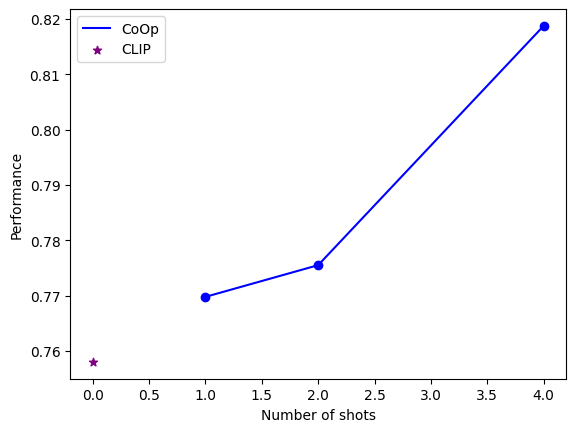

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经收集了一些实验结果
clip_results = [0.758, 0.755, 0.761]  # zero-shot CLIP的结果
coop_results = [[0.7703, 0.7591, 0.7799], [0.7598, 0.7965, 0.7702], [0.8102, 0.8298, 0.8163]]  # CoOp的结果，分别对应1-shot, 2-shot, 4-shot

# 计算均值
clip_mean = np.mean(clip_results)
coop_means = [np.mean(x) for x in coop_results]

# 绘制结果图
plt.plot([1, 2, 4], coop_means, label='CoOp', color='blue')
plt.scatter([1, 2, 4], coop_means, color='blue')
plt.scatter([0], [clip_mean], label='CLIP', color='purple', marker='*')
plt.xlabel('Number of shots')
plt.ylabel('Performance')
plt.legend()
plt.show()
